In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import bitstring
import os
import heapq
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
from skimage import data, color

In [3]:
import numpy as np
from scipy.ndimage import sobel

In [4]:
def compute_gradients(image):
    """Compute gradient magnitude and direction using Sobel filters."""
    grad_x = sobel(image, axis=1)  # Gradient along x-axis
    grad_y = sobel(image, axis=0)  # Gradient along y-axis

    magnitude = np.sqrt(grad_x**2 + grad_y**2)  # Gradient magnitude
    direction = np.arctan2(grad_y, grad_x)  # Gradient direction (radians)
    direction = np.rad2deg(direction)  # Convert to degrees
    direction = (direction + 360) % 360  # Normalize to [0, 360)

    return magnitude, direction

def classify_blocks_by_gradient(image, block_size=8):
    """Classify 8x8 blocks based on gradient direction."""
    height, width = image.shape
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    _, direction = compute_gradients(image)

    # Gradient direction bins (in degrees)
    bins = np.linspace(0, 180, 9)  # 8 bins, [0, 22.5, ..., 157.5]
    # block_classes = np.zeros(num_blocks_y*num_blocks_x, dtype=int)
    labels = []
    blocks = []

    for by in range(num_blocks_y):
        for bx in range(num_blocks_x):
            # Extract block
            block = image[
                by * block_size:(by + 1) * block_size,
                bx * block_size:(bx + 1) * block_size,
            ]
            blocks.append(block.flatten())

            block_direction = direction[
                by * block_size:(by + 1) * block_size,
                bx * block_size:(bx + 1) * block_size,
            ]

            # Histogram of directions within the block
            hist, _ = np.histogram(block_direction, bins=bins)

            # Classify based on the bin with the most votes
            labels.append(np.argmax(hist))

    return np.array(labels), np.array(blocks)



# Load an example grayscale image
image1 = color.rgb2gray(data.astronaut())
image2 = data.gravel()
# image = (image*255).astype(np.uint8)
# Classify blocks by gradient direction
labels1, blocks1 = classify_blocks_by_gradient(image1)
labels2, blocks2 = classify_blocks_by_gradient(image2)

labels = np.concatenate((labels1, labels2), axis=0)
blocks = np.concatenate((blocks1, blocks2), axis=0)

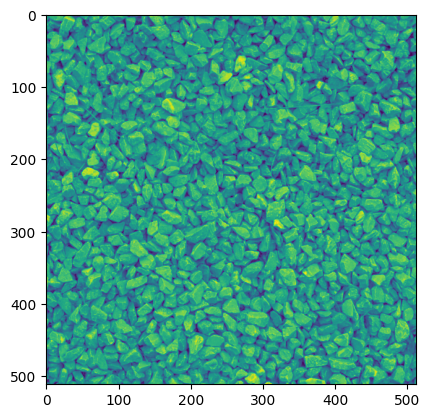

In [5]:
plt.imshow(data.gravel())

In [6]:
print(blocks)

[[5.83434902e-01 4.14859216e-01 2.44058431e-01 ... 7.89298824e-01
  7.17311765e-01 5.87066667e-01]
 [5.57926275e-01 5.30192549e-01 4.56516078e-01 ... 3.69811765e-02
  3.02698039e-02 1.73819608e-02]
 [6.45137255e-03 3.64588235e-03 7.85019608e-03 ... 2.32678431e-02
  3.44662745e-02 3.80972549e-02]
 ...
 [1.61000000e+02 1.66000000e+02 1.58000000e+02 ... 1.20000000e+02
  8.00000000e+01 7.00000000e+01]
 [9.40000000e+01 1.27000000e+02 1.35000000e+02 ... 4.80000000e+01
  7.40000000e+01 9.30000000e+01]
 [1.16000000e+02 1.11000000e+02 1.06000000e+02 ... 8.30000000e+01
  1.12000000e+02 1.58000000e+02]]


In [7]:
blocks = blocks*255
print(blocks)

[[1.487759e+02 1.057891e+02 6.223490e+01 ... 2.012712e+02 1.829145e+02
  1.497020e+02]
 [1.422712e+02 1.351991e+02 1.164116e+02 ... 9.430200e+00 7.718800e+00
  4.432400e+00]
 [1.645100e+00 9.297000e-01 2.001800e+00 ... 5.933300e+00 8.788900e+00
  9.714800e+00]
 ...
 [4.105500e+04 4.233000e+04 4.029000e+04 ... 3.060000e+04 2.040000e+04
  1.785000e+04]
 [2.397000e+04 3.238500e+04 3.442500e+04 ... 1.224000e+04 1.887000e+04
  2.371500e+04]
 [2.958000e+04 2.830500e+04 2.703000e+04 ... 2.116500e+04 2.856000e+04
  4.029000e+04]]


In [8]:
coeffs = np.zeros(blocks.shape)

In [ ]:
def get_opt_coeff_given_transform(G_i, blocks, lam):
    '''
    G_i is NxN, blocks should be CxN (flattened from sqrtN x sqrtN)
    return c_ij (should be CxN)
    '''
    coeffs = blocks @ G_i
    coeffs[np.abs(coeffs) < np.sqrt(lam)] = 0
    
    return coeffs

def get_opt_transform_given_coeff(c_i, x):
    '''
    x should be a numpy array CxN, where C is total no of blocks, c_i should be a numpy array CxN, corresponding to x
    '''
    Y = c_i.T @ x
    U, _, V = np.linalg.svd(Y, full_matrices=False)

    G_i = V @ U.T
    return G_i

In [10]:
transforms = []
for _ in range(8):
    transforms.append(np.ones((64,64)))

In [ ]:
def algorithm_1(transform, lam, blocks):
    '''
    transform NxN, coeffs CxN, blocks CxN
    '''
    prev_transform = np.zeros(transform.shape)
    coeffs = None
    while(np.mean((transform-prev_transform)**2) > 0.05):
        prev_transform = transform
        coeffs = get_opt_coeff_given_transform(G_i=transform, blocks=blocks, lam=lam)
        transform = get_opt_transform_given_coeff(c_i=coeffs, x=blocks)
    return transform

In [12]:
import tqdm

In [ ]:
def algorithm_2(transforms,blocks, labels, lam_max=200, lam_min=20, lam_diff=20):
    lam = lam_max
    old_labels = np.zeros_like(labels)
    cnt = 0
    while(not np.array_equal(old_labels, labels)):
        cnt += 1
        if cnt > 100:
            break
        old_labels = labels
        while lam > lam_min:
            for i in range(8):
                reqd_blocks = blocks[np.where(labels == i)[0]]
                transforms[i] = algorithm_1(transform=transforms[i], lam=lam, blocks=reqd_blocks)
            for i in range(blocks.shape[0]):
                costs = np.zeros(8)
                for k in range(8):
                    coeff = get_opt_coeff_given_transform(transforms[k], blocks[i], lam)
                    costs[k] = np.sum((blocks[i]-coeff@transforms[k])**2)+lam*(np.count_nonzero(coeff))
                new_label = np.argmin(costs)
                labels[i] = new_label

            lam -= lam_diff
        lam = lam_max
        print(cnt)
        print(np.sum(old_labels != labels))
    return transforms


In [14]:
transforms = []
for _ in range(8):
    transforms.append(np.ones((64,64)))

In [15]:
final_transforms = algorithm_2(transforms, blocks, labels)

1
0


In [16]:
print(transforms[0])

[[ 0.1278943   0.21631691  0.08051027 ...  0.11724868 -0.14800293
   0.08626811]
 [-0.02963285 -0.11851365  0.09362545 ...  0.2939561   0.01518199
  -0.0646996 ]
 [-0.02526793  0.12348203 -0.08870698 ...  0.10139794 -0.00168394
   0.1186282 ]
 ...
 [ 0.02728437 -0.07627156  0.0568307  ... -0.11580945  0.1736808
  -0.32499965]
 [ 0.05667945 -0.06138867 -0.01830333 ...  0.17298429 -0.12718547
  -0.02351669]
 [ 0.01945372  0.17201466 -0.19069839 ... -0.20700094  0.02766444
  -0.14811291]]


In [ ]:
class JPEG_SOT:
    def __init__(self, Q = 50, lam=10000):
        self.Q = Q
        self.quantization_matrix = np.array([   [16, 11, 10, 16, 24, 40, 51, 61],
                                                [12, 12, 14, 19, 26, 58, 60, 55],
                                                [14, 13, 16, 24, 40, 57, 69, 56],
                                                [14, 17, 22, 29, 51, 87, 80, 62],
                                                [18, 22, 37, 56, 68, 109, 103, 77],
                                                    [24, 35, 55, 64, 81, 104, 113, 92],
                                                [49, 64, 78, 87, 103, 121, 120, 101],
                                                [72, 92, 95, 98, 112, 100, 103, 99],])
        self.scaled_quantization_matrix = np.round(self.quantization_matrix * (50.0/Q))
        self.transforms = transforms
        self.block_to_transform = {}
        self.lam = lam
    
    # define the dct and idct functions for the blocks
    def t(self, block):
        flat_block = block.flatten()
        flat_block = np.reshape(flat_block, (1,64))
        costs = np.zeros(8)
        for i in range(8):
            coeff = get_opt_coeff_given_transform(self.transforms[i], flat_block, self.lam)
            costs[i] = np.sum((flat_block-coeff@self.transforms[i])**2)+self.lam*(np.count_nonzero(coeff))
        best_transform = self.transforms[np.argmin(costs)]
        return np.reshape(get_opt_coeff_given_transform(best_transform, flat_block, self.lam), (8,8)), best_transform

    def it(self, block, transform):
        return np.reshape((transform @ block.flatten()), (8,8))
    
    # Runs quantization while compression
    def _quantize(self, block):
        return np.round(block / self.scaled_quantization_matrix)

    # Runs dequantization while decompression
    def _dequantize(self, block):
        return block * self.scaled_quantization_matrix
    
    # breaks the image into 8x8 patches
    def _chunkify(self, image):
        chunks = []
        h,w = np.shape(image)
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                chunk = image[i:i+8, j:j+8]
                chunks.append(chunk)

        return chunks

    # recombines the patches into the original image size
    def _dechunkify(self, chunks, original_shape):
        h, w = original_shape
        image = np.zeros((h, w), dtype=chunks[0].dtype)  # Create an empty array with the original shape
        chunk_idx = 0  # Index to keep track of the current chunk

        for i in range(0, h, 8):
            for j in range(0, w, 8):
                # Place the current chunk into the corresponding position in the image
                image[i:i+8, j:j+8] = chunks[chunk_idx]
                chunk_idx += 1

        return image

    # flattens the matrix into its zig-zag traversal
    def _zigzag(self, matrix):
        rows, cols = matrix.shape
        result = []

        for s in range(rows + cols - 1):
            if s % 2 == 0:  # Even diagonals (move up-right)
                x = min(s, rows - 1)
                y = s - x
                while x >= 0 and y < cols:
                    result.append(matrix[x, y])
                    x -= 1
                    y += 1
            else:  # Odd diagonals (move down-left)
                y = min(s, cols - 1)
                x = s - y
                while y >= 0 and x < rows:
                    result.append(matrix[x, y])
                    x += 1
                    y -= 1

        return np.array(result)

    # converts a flattened matrix into the original form by placing the elements in a zig zag manner
    def _reverse_zigzag(self, flattened, rows, cols):
        # Initialize an empty 2D matrix
        matrix = np.zeros((rows, cols), dtype=flattened.dtype)

        # Fill the matrix using the reverse zig-zag order
        index = 0
        for s in range(rows + cols - 1):
            if s % 2 == 0:  # Even diagonals (move up-right)
                x = min(s, rows - 1)
                y = s - x
                while x >= 0 and y < cols:
                    matrix[x, y] = flattened[index]
                    index += 1
                    x -= 1
                    y += 1
            else:  # Odd diagonals (move down-left)
                y = min(s, cols - 1)
                x = s - y
                while y >= 0 and x < rows:
                    matrix[x, y] = flattened[index]
                    index += 1
                    x += 1
                    y -= 1

        return matrix
    
    # Helper functions for huffman encoding and RLE
    def _build_huffman_tree(self, frequencies):
        # Create a priority queue (min-heap) to build the Huffman tree
        heap = [[weight, [symbol, ""]] for symbol, weight in frequencies.items()]
        heapq.heapify(heap)
        
        while len(heap) > 1:
            low = heapq.heappop(heap)
            high = heapq.heappop(heap)
            for pair in low[1:]:
                pair[1] = '0' + pair[1]
            for pair in high[1:]:
                pair[1] = '1' + pair[1]
            heapq.heappush(heap, [low[0] + high[0]] + low[1:] + high[1:])
        
        # Generate the Huffman codes
        huffman_codes = {}
        for symbol, code in heap[0][1:]:
            huffman_codes[symbol] = code
        return huffman_codes

    def _run_length_encoding(self, matrix):
        rle = []
        zero_count = 0
        
        for value in matrix:
            if value == 0:
                zero_count += 1  # Increment zero counter
                if zero_count == 16:
                    rle.append((15, 0))
                    zero_count = 0
            else:
                rle.append((zero_count, value))  # Store the number of zeros before the value
                zero_count = 0  # Reset zero counter after encountering a non-zero value
        
        return rle

    def _huffman_encoding(self, values):
        frequencies = defaultdict(int)
        for val in values:
            frequencies[val] += 1
        
        huffman_codes = self._build_huffman_tree(frequencies)
        return huffman_codes

    # Function to encode the image post scaling dct and quantization into rle and huffman and store into a bin file
    def _encode(self, flattened_matrices, filename):
        with open(filename, 'wb') as f:
            rle_result = []

            for i in range(0,len(flattened_matrices)):
                rle = self._run_length_encoding(flattened_matrices[i])
                rle_result.extend(rle)
                rle_result.append((0,0))

            values = [value for count, value in rle_result]  # Only values for Huffman encoding
            huffman_codes = self._huffman_encoding(values)    

            # Store the Quality Factor in the file 
            f.write(np.array([self.Q], dtype=np.uint8).tobytes()) 
            f.flush()
        

            # Store the Huffman table in the file (value -> huffman code mapping)
            f.write(np.array([len(huffman_codes)], dtype=np.uint16).tobytes())  # Write the number of unique values in Huffman table
            f.flush()            
 

            # Collect all Huffman codes
            all_huffman_codes = []

            for value, code in huffman_codes.items():
                f.write(np.array([value], dtype=np.int16).tobytes())  
                f.flush()
                size_in_bits = len(code)
                f.write(np.array([size_in_bits], dtype=np.uint8).tobytes())  # Write the size of the Huffman code
                f.flush()
                all_huffman_codes.append(code)

            all_huffman_codes_str = ''.join(all_huffman_codes)
            total_size_in_bits = len(all_huffman_codes_str)

            f.write(np.array([total_size_in_bits], dtype=np.uint32).tobytes())
            f.flush()

            padding_length = 0
            if len(all_huffman_codes_str) % 8 != 0:
                padding_length = 8 - (len(all_huffman_codes_str) % 8)
            all_huffman_codes_str = all_huffman_codes_str + '0' * padding_length

            bitstream = bitstring.BitStream(bin=all_huffman_codes_str)
            f.write(bitstream.bytes)  # Write the Huffman code as bytes
            f.flush()

            # To store the RLE Result
            # Store the size of the rle_result
            f.write(np.array([len(rle_result)], dtype=np.uint32).tobytes())  
            f.flush()            

            all_huffman_codes = []
            all_huffman_codes_str = ''

            for count, value in rle_result:
                huffman_code = huffman_codes[value]  # Find Huffman code for this value
                size_in_bits = len(huffman_code)  # The size in bits of the Huffman code

                f.write(np.array([count], dtype=np.uint8).tobytes())
                f.write(np.array([size_in_bits], dtype=np.uint8).tobytes())

                f.flush()

                all_huffman_codes.append(huffman_code)

            all_huffman_codes_str = ''.join(all_huffman_codes)
            total_size_in_bits = len(all_huffman_codes_str)

            # Calculate padding to ensure byte alignment
            if total_size_in_bits % 8 != 0:
                padding_length = 8 - (total_size_in_bits % 8)
                all_huffman_codes_str += '0' * padding_length  # Add padding to the bitstream
            else:
                padding_length = 0

            # Write the total size in bits to the file (before padding)
            f.write(np.array([total_size_in_bits], dtype=np.uint32).tobytes())
            f.flush()

            # Convert the padded bitstream into a byte array
            bitstream = bitstring.BitStream(bin=all_huffman_codes_str)
            f.write(bitstream.bytes)  # Write the Huffman codes as bytes
            f.flush()



    # Finds the original value given the huffman code and the huffman table
    def _decode_huffman_code(self, code_bits, huffman_codes):
        # Reverse the Huffman coding to find the value for the given code bits
        for value, huffman_code in huffman_codes.items():
            if code_bits == huffman_code:
                return value
        raise ValueError(f"Unknown Huffman code: {code_bits}")

    # takes as input the original image and a quality factor Q
    def compress(self, image, filename):
        image = image.astype('float32') # cast to float
        image = image - 128.0 # rescale the values
        chunks = self._chunkify(image) # break into 8x8 chunks 
        
        flattened_matrices = []
        for i, chunk in enumerate(chunks):
            val, transform = self.t(chunk)
            quantized_matrix = self._quantize(val)
            flattened_matrix = self._zigzag(quantized_matrix)
            flattened_matrices.append(flattened_matrix)
            self.block_to_transform[i] = transform

        self._encode(flattened_matrices, filename)

    def decompress(self, filename):
        with open(filename, 'rb') as f:
            # Read the Quality Factor (Q)
            Q = np.fromfile(f, dtype=np.uint8, count=1)[0]
            
            # Read the Huffman table (number of entries)
            num_huffman_codes = np.fromfile(f, dtype=np.uint16, count=1)[0]

            huffman_codes = {}
            
            table_entries = []
            # Read each Huffman code (value, size)
            for _ in range(num_huffman_codes):
                value = np.fromfile(f, dtype=np.int16, count=1)[0]
                size_in_bits = np.fromfile(f, dtype=np.uint8, count=1)[0]
                table_entries.append((value,size_in_bits))
            
            length_huffman_codes = np.fromfile(f, dtype=np.uint32, count=1)[0]
            huffman_codes_bitstream = f.read((length_huffman_codes + 7) // 8)  # Read the total size in bytes
            huffman_codes_bitstream = bitstring.BitStream(bytes=huffman_codes_bitstream).bin

            current_pos = 0
            for value, size_in_bits in table_entries:
                huffman_codes[value] = huffman_codes_bitstream[current_pos:current_pos+size_in_bits]
                current_pos+=size_in_bits
            

            # get the number of rle values
            num_rle_values = np.fromfile(f, dtype=np.uint32, count=1)[0]

            # 3. Decode the RLE-encoded values and sizes
            rle_result = []
            table_entries = []

            for _ in range(num_rle_values):
                count = np.fromfile(f, dtype=np.uint8, count=1)[0]
                size_in_bits = np.fromfile(f, dtype=np.uint8, count=1)[0]
                table_entries.append((count, size_in_bits))
            
            # print(table_entries)
            
            length_huffman_codes = np.fromfile(f, dtype=np.uint32, count=1)[0]
            huffman_codes_bitstream = f.read((length_huffman_codes + 7) // 8)  # Read the total size in bytes
            huffman_codes_bitstream = bitstring.BitStream(bytes=huffman_codes_bitstream).bin

            current_pos = 0
            for count, size_in_bits in table_entries:
                value = self._decode_huffman_code(huffman_codes_bitstream[current_pos:current_pos+size_in_bits], huffman_codes)
                rle_result.append((count, value))
                current_pos+=size_in_bits


            # Reconstruct the original flattened matrices from RLE
            flattened_matrices = []
            
            current_patch = []
            for count, value in rle_result:
                if count == 0 and value == 0:
                    current_patch = current_patch + [0]*(64 - len(current_patch))
                    flattened_matrices.append(np.array(current_patch))
                    current_patch = []
                else:
                    current_patch = current_patch + [0]*count + [value]


            # convert it back to the original patch dimensions
            for i in range(len(flattened_matrices)):
                
                flattened_matrices[i] = self._reverse_zigzag(flattened_matrices[i], 8, 8)

                # now de-quantize the matrix and rescale
                flattened_matrices[i] = (flattened_matrices[i] * self.scaled_quantization_matrix) 
                flattened_matrices[i] = self.it(flattened_matrices[i], self.block_to_transform[i]) + 128
            
            # combine the patches together
            restored_image = self._dechunkify(flattened_matrices, (8*int(np.sqrt(len(flattened_matrices))), 8*int(np.sqrt(len(flattened_matrices)))))
            return restored_image


In [18]:
image = cv2.imread('data/airplaneU2.bmp', cv2.IMREAD_GRAYSCALE)
jpeg_sot = JPEG_SOT(Q=10, lam=10000)
jpeg_sot.compress(image, "test_sot")

# Example usage:
filename = "test_sot"
restored_image = jpeg_sot.decompress(filename)

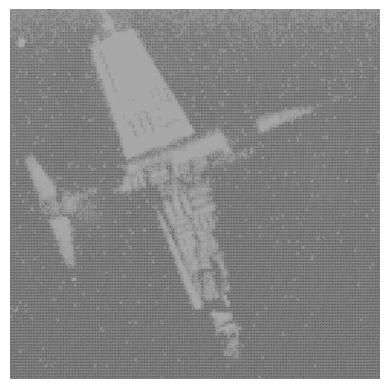

In [19]:
plt.imshow(restored_image, cmap='gray')  # Use grayscale colormap
plt.axis("off")
plt.show()

In [20]:
file_size_in_bits_comp = os.path.getsize(filename) * 8
print(file_size_in_bits_comp)

3980608


In [21]:
file_size_in_bits_og = os.path.getsize('data/airplaneU2.bmp') * 8
print(file_size_in_bits_og)

8397232


# Analysis and Comparison with Implemented JPEG

In [22]:
def calculate_rmse(original_image, decompressed_image):
    # Flatten the images to 1D arrays for easier comparison
    original_image = original_image.astype(np.float64)
    decompressed_image = decompressed_image.astype(np.float64)

    # Compute the squared differences
    squared_diff = (original_image - decompressed_image) ** 2

    # Calculate the mean squared error (MSE)
    mse = np.mean(squared_diff)

    # RMSE is the square root of MSE
    rmse = np.sqrt(mse)
    
    return rmse

def calculate_bpp(compressed_image_path, image_shape):
    # Get the compressed file size in bits (1 byte = 8 bits)
    file_size_in_bits = os.path.getsize(compressed_image_path) * 8

    # Calculate the total number of pixels in the image
    num_pixels = image_shape[0] * image_shape[1]

    # Compute BPP
    bpp = file_size_in_bits / num_pixels

    return bpp

def psnr(original, compressed):
    original_image = original_image.astype(np.float64)
    decompressed_image = decompressed_image.astype(np.float64)
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100  # If MSE is zero, PSNR is infinite (no difference).
    max_pixel = 255.0
    psnr_value = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr_value

In [23]:
class JPEG:
    def __init__(self, Q = 50):
        self.Q = Q
        self.quantization_matrix = np.array([   [16, 11, 10, 16, 24, 40, 51, 61],
                                                [12, 12, 14, 19, 26, 58, 60, 55],
                                                [14, 13, 16, 24, 40, 57, 69, 56],
                                                [14, 17, 22, 29, 51, 87, 80, 62],
                                                [18, 22, 37, 56, 68, 109, 103, 77],
                                                [24, 35, 55, 64, 81, 104, 113, 92],
                                                [49, 64, 78, 87, 103, 121, 120, 101],
                                                [72, 92, 95, 98, 112, 100, 103, 99],])
        self.scaled_quantization_matrix = np.round(self.quantization_matrix * (50.0/Q))
    
    # define the dct and idct functions for the blocks
    def _dct2(self, block):
        dct_val = dct(dct(block.T, norm='ortho').T, norm='ortho')
        return dct_val

    def _idct2(self, block):
        return idct(idct(block.T, norm='ortho').T, norm='ortho')
    
    # Runs quantization while compression
    def _quantize(self, block):
        return np.round(block / self.scaled_quantization_matrix)

    # Runs dequantization while decompression
    def _dequantize(self, block):
        return block * self.scaled_quantization_matrix
    
    # breaks the image into 8x8 patches
    def _chunkify(self, image):
        chunks = []
        h,w = np.shape(image)
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                chunk = image[i:i+8, j:j+8]
                chunks.append(chunk)

        return chunks

    # recombines the patches into the original image size
    def _dechunkify(self, chunks, original_shape):
        h, w = original_shape
        image = np.zeros((h, w), dtype=chunks[0].dtype)  # Create an empty array with the original shape
        chunk_idx = 0  # Index to keep track of the current chunk

        for i in range(0, h, 8):
            for j in range(0, w, 8):
                # Place the current chunk into the corresponding position in the image
                image[i:i+8, j:j+8] = chunks[chunk_idx]
                chunk_idx += 1

        return image

    # flattens the matrix into its zig-zag traversal
    def _zigzag(self, matrix):
        rows, cols = matrix.shape
        result = []

        for s in range(rows + cols - 1):
            if s % 2 == 0:  # Even diagonals (move up-right)
                x = min(s, rows - 1)
                y = s - x
                while x >= 0 and y < cols:
                    result.append(matrix[x, y])
                    x -= 1
                    y += 1
            else:  # Odd diagonals (move down-left)
                y = min(s, cols - 1)
                x = s - y
                while y >= 0 and x < rows:
                    result.append(matrix[x, y])
                    x += 1
                    y -= 1

        return np.array(result)

    # converts a flattened matrix into the original form by placing the elements in a zig zag manner
    def _reverse_zigzag(self, flattened, rows, cols):
        # Initialize an empty 2D matrix
        matrix = np.zeros((rows, cols), dtype=flattened.dtype)

        # Fill the matrix using the reverse zig-zag order
        index = 0
        for s in range(rows + cols - 1):
            if s % 2 == 0:  # Even diagonals (move up-right)
                x = min(s, rows - 1)
                y = s - x
                while x >= 0 and y < cols:
                    matrix[x, y] = flattened[index]
                    index += 1
                    x -= 1
                    y += 1
            else:  # Odd diagonals (move down-left)
                y = min(s, cols - 1)
                x = s - y
                while y >= 0 and x < rows:
                    matrix[x, y] = flattened[index]
                    index += 1
                    x += 1
                    y -= 1

        return matrix
    
    # Helper functions for huffman encoding and RLE
    def _build_huffman_tree(self, frequencies):
        # Create a priority queue (min-heap) to build the Huffman tree
        heap = [[weight, [symbol, ""]] for symbol, weight in frequencies.items()]
        heapq.heapify(heap)
        
        while len(heap) > 1:
            low = heapq.heappop(heap)
            high = heapq.heappop(heap)
            for pair in low[1:]:
                pair[1] = '0' + pair[1]
            for pair in high[1:]:
                pair[1] = '1' + pair[1]
            heapq.heappush(heap, [low[0] + high[0]] + low[1:] + high[1:])
        
        # Generate the Huffman codes
        huffman_codes = {}
        for symbol, code in heap[0][1:]:
            huffman_codes[symbol] = code
        return huffman_codes

    def _run_length_encoding(self, matrix):
        rle = []
        zero_count = 0
        
        for value in matrix:
            if value == 0:
                zero_count += 1  # Increment zero counter
                if zero_count == 16:
                    rle.append((15, 0))
                    zero_count = 0
            else:
                rle.append((zero_count, value))  # Store the number of zeros before the value
                zero_count = 0  # Reset zero counter after encountering a non-zero value
        
        return rle

    def _huffman_encoding(self, values):
        frequencies = defaultdict(int)
        for val in values:
            frequencies[val] += 1
        
        huffman_codes = self._build_huffman_tree(frequencies)
        return huffman_codes

    # Function to encode the image post scaling dct and quantization into rle and huffman and store into a bin file
    def _encode(self, flattened_matrices, filename):
        with open(filename, 'wb') as f:
            rle_result = []

            for i in range(0,len(flattened_matrices)):
                rle = self._run_length_encoding(flattened_matrices[i])
                rle_result.extend(rle)
                rle_result.append((0,0))

            values = [value for count, value in rle_result]  # Only values for Huffman encoding
            huffman_codes = self._huffman_encoding(values)    

            # Store the Quality Factor in the file 
            f.write(np.array([self.Q], dtype=np.uint8).tobytes()) 
            f.flush()
        

            # Store the Huffman table in the file (value -> huffman code mapping)
            f.write(np.array([len(huffman_codes)], dtype=np.uint16).tobytes())  # Write the number of unique values in Huffman table
            f.flush()            
 

            # Collect all Huffman codes
            all_huffman_codes = []

            for value, code in huffman_codes.items():
                f.write(np.array([value], dtype=np.int16).tobytes())  
                f.flush()
                size_in_bits = len(code)
                f.write(np.array([size_in_bits], dtype=np.uint8).tobytes())  # Write the size of the Huffman code
                f.flush()
                all_huffman_codes.append(code)

            all_huffman_codes_str = ''.join(all_huffman_codes)
            total_size_in_bits = len(all_huffman_codes_str)

            f.write(np.array([total_size_in_bits], dtype=np.uint32).tobytes())
            f.flush()

            padding_length = 0
            if len(all_huffman_codes_str) % 8 != 0:
                padding_length = 8 - (len(all_huffman_codes_str) % 8)
            all_huffman_codes_str = all_huffman_codes_str + '0' * padding_length

            bitstream = bitstring.BitStream(bin=all_huffman_codes_str)
            f.write(bitstream.bytes)  # Write the Huffman code as bytes
            f.flush()

            # To store the RLE Result
            # Store the size of the rle_result
            f.write(np.array([len(rle_result)], dtype=np.uint32).tobytes())  
            f.flush()            

            all_huffman_codes = []
            all_huffman_codes_str = ''

            for count, value in rle_result:
                huffman_code = huffman_codes[value]  # Find Huffman code for this value
                size_in_bits = len(huffman_code)  # The size in bits of the Huffman code

                f.write(np.array([count], dtype=np.uint8).tobytes())
                f.write(np.array([size_in_bits], dtype=np.uint8).tobytes())

                f.flush()

                all_huffman_codes.append(huffman_code)

            all_huffman_codes_str = ''.join(all_huffman_codes)
            total_size_in_bits = len(all_huffman_codes_str)

            # Calculate padding to ensure byte alignment
            if total_size_in_bits % 8 != 0:
                padding_length = 8 - (total_size_in_bits % 8)
                all_huffman_codes_str += '0' * padding_length  # Add padding to the bitstream
            else:
                padding_length = 0

            # Write the total size in bits to the file (before padding)
            f.write(np.array([total_size_in_bits], dtype=np.uint32).tobytes())
            f.flush()

            # Convert the padded bitstream into a byte array
            bitstream = bitstring.BitStream(bin=all_huffman_codes_str)
            f.write(bitstream.bytes)  # Write the Huffman codes as bytes
            f.flush()



    # Finds the original value given the huffman code and the huffman table
    def _decode_huffman_code(self, code_bits, huffman_codes):
        # Reverse the Huffman coding to find the value for the given code bits
        for value, huffman_code in huffman_codes.items():
            if code_bits == huffman_code:
                return value
        raise ValueError(f"Unknown Huffman code: {code_bits}")

    # takes as input the original image and a quality factor Q
    def compress(self, image, filename):
        image = image.astype('float32') # cast to float
        image = image - 128.0 # rescale the values
        chunks = self._chunkify(image) # break into 8x8 chunks 
        
        flattened_matrices = []
        for chunk in chunks:
            quantized_matrix = self._quantize(self._dct2(chunk))
            flattened_matrix = self._zigzag(quantized_matrix)
            flattened_matrices.append(flattened_matrix)

        self._encode(flattened_matrices, filename)

    def decompress(self, filename):
        with open(filename, 'rb') as f:
            # Read the Quality Factor (Q)
            Q = np.fromfile(f, dtype=np.uint8, count=1)[0]
            
            # Read the Huffman table (number of entries)
            num_huffman_codes = np.fromfile(f, dtype=np.uint16, count=1)[0]

            huffman_codes = {}
            
            table_entries = []
            # Read each Huffman code (value, size)
            for _ in range(num_huffman_codes):
                value = np.fromfile(f, dtype=np.int16, count=1)[0]
                size_in_bits = np.fromfile(f, dtype=np.uint8, count=1)[0]
                table_entries.append((value,size_in_bits))
            
            length_huffman_codes = np.fromfile(f, dtype=np.uint32, count=1)[0]
            huffman_codes_bitstream = f.read((length_huffman_codes + 7) // 8)  # Read the total size in bytes
            huffman_codes_bitstream = bitstring.BitStream(bytes=huffman_codes_bitstream).bin

            current_pos = 0
            for value, size_in_bits in table_entries:
                huffman_codes[value] = huffman_codes_bitstream[current_pos:current_pos+size_in_bits]
                current_pos+=size_in_bits
            

            # get the number of rle values
            num_rle_values = np.fromfile(f, dtype=np.uint32, count=1)[0]

            # 3. Decode the RLE-encoded values and sizes
            rle_result = []
            table_entries = []

            for _ in range(num_rle_values):
                count = np.fromfile(f, dtype=np.uint8, count=1)[0]
                size_in_bits = np.fromfile(f, dtype=np.uint8, count=1)[0]
                table_entries.append((count, size_in_bits))
            
            # print(table_entries)
            
            length_huffman_codes = np.fromfile(f, dtype=np.uint32, count=1)[0]
            huffman_codes_bitstream = f.read((length_huffman_codes + 7) // 8)  # Read the total size in bytes
            huffman_codes_bitstream = bitstring.BitStream(bytes=huffman_codes_bitstream).bin

            current_pos = 0
            for count, size_in_bits in table_entries:
                value = self._decode_huffman_code(huffman_codes_bitstream[current_pos:current_pos+size_in_bits], huffman_codes)
                rle_result.append((count, value))
                current_pos+=size_in_bits


            # Reconstruct the original flattened matrices from RLE
            flattened_matrices = []
            
            current_patch = []
            for count, value in rle_result:
                if count == 0 and value == 0:
                    current_patch = current_patch + [0]*(64 - len(current_patch))
                    flattened_matrices.append(np.array(current_patch))
                    current_patch = []
                else:
                    current_patch = current_patch + [0]*count + [value]


            # convert it back to the original patch dimensions
            for i in range(len(flattened_matrices)):
                
                flattened_matrices[i] = self._reverse_zigzag(flattened_matrices[i], 8, 8)

                # now de-quantize the matrix and rescale
                flattened_matrices[i] = (flattened_matrices[i] * self.scaled_quantization_matrix) 
                flattened_matrices[i] = self._idct2(flattened_matrices[i]) + 128
            
            # combine the patches together
            restored_image = self._dechunkify(flattened_matrices, (8*int(np.sqrt(len(flattened_matrices))), 8*int(np.sqrt(len(flattened_matrices)))))
            return restored_image


In [28]:
quality_factors = range(10, 101, 10)  # Quality factors from 10 to 100 in steps of 10
images_directory = "data/"  # Directory with at least 20 images
output_directory = "results/compressed_images_sot_custom/"  # Directory to save compressed images
graphs_directory = "results/sot_comparison/"
compressed_images_directory = "compressed_images/"

# Process images
image_files = [os.path.join(images_directory, f) for f in os.listdir(images_directory)]

# Loop through each image and process
for image_path in image_files:
    rmse_values_sot = []
    bpp_values_sot = []
    rmse_values_custom = []
    bpp_values_custom = []
    compression_rate_sot = []
    compression_rate_custom = []
    
    for q in quality_factors:
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the SOT compressed image
        compressed_path_sot = os.path.join(compressed_images_directory, f"sot_compressed_q{q}_{os.path.splitext(os.path.basename(image_path))[0]}")
        jpeg_sot = JPEG_SOT(Q=q, lam=10000)
        jpeg_sot.compress(original_image, compressed_path_sot)
        decompressed_image_sot = jpeg_sot.decompress(compressed_path_sot)

        decompressed_image_path_sot = os.path.join(output_directory, f"sot_compressed_q{q}_{os.path.splitext(os.path.basename(image_path))[0]}.jpg")

        # Save the decompressed sot image as a .jpg file
        cv2.imwrite(decompressed_image_path_sot, decompressed_image_sot)

        # Calculate RMSE and BPP for SOT
        rmse_sot = calculate_rmse(original_image, decompressed_image_sot)
        bpp_sot = calculate_bpp(compressed_path_sot, original_image.shape)

        # Calculate Compression Rate for SOT
        original_size_sot = os.path.getsize(image_path)
        compressed_size_sot = os.path.getsize(compressed_path_sot)
        compression_rate_sot.append(original_size_sot / compressed_size_sot)

        rmse_values_sot.append(rmse_sot)
        bpp_values_sot.append(bpp_sot)

        # Custom JPEG Compression (assuming custom JPEG class is defined)
        jpeg = JPEG(Q=q)  # Assuming your custom JPEG implementation is called 'JPEG'
        
        compressed_path_custom = os.path.join(compressed_images_directory, f"custom_compressed_q{q}_{os.path.splitext(os.path.basename(image_path))[0]}")
        jpeg.compress(original_image, compressed_path_custom)  
        decompressed_image_custom = jpeg.decompress(compressed_path_custom)  # Decompress using custom method

        decompressed_image_path_custom = os.path.join(output_directory, f"custom_compressed_q{q}_{os.path.splitext(os.path.basename(image_path))[0]}.jpg")

        # Save the decompressed custom image as a .jpg file
        cv2.imwrite(decompressed_image_path_custom, decompressed_image_custom)

        # Check for shape mismatch
        if original_image.shape != decompressed_image_custom.shape:
            print(f"Error in image_path: {image_path}, Quality Factor: {q}")
            continue

        # Calculate RMSE and BPP for custom method
        rmse_custom = calculate_rmse(original_image, decompressed_image_custom)
        bpp_custom = calculate_bpp(compressed_path_custom, original_image.shape)

        # Calculate Compression Rate for custom method
        original_size_custom = os.path.getsize(image_path)
        compressed_size_custom = os.path.getsize(compressed_path_custom)
        compression_rate_custom.append(original_size_custom / compressed_size_custom)
    
        rmse_values_custom.append(rmse_custom)
        bpp_values_custom.append(bpp_custom)

    # Plot the comparison of RMSE vs BPP for both methods (SOT vs Custom JPEG)
    plt.figure(figsize=(8, 6))
    plt.plot(bpp_values_sot, rmse_values_sot, marker='o', linestyle='-', label='SOT JPEG', color='blue')
    plt.plot(bpp_values_custom, rmse_values_custom, marker='x', linestyle='-', label='Custom JPEG', color='red')
    plt.xlabel('Bits Per Pixel (BPP)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title(f'RMSE vs BPP for Image {os.path.splitext(os.path.basename(image_path))[0]}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save the comparison plot
    plot_filename = os.path.join(graphs_directory, f"rmse_vs_bpp_comparison_{os.path.splitext(os.path.basename(image_path))[0]}.png")
    plt.savefig(plot_filename)
    plt.close()  # Close the figure to avoid overlapping plots

    # Plot Compression Rate vs Quality Factor for both methods (SOT vs Custom JPEG)
    plt.figure(figsize=(8, 6))
    plt.plot(quality_factors, compression_rate_sot, marker='o', linestyle='-', label='SOT JPEG', color='blue')
    plt.plot(quality_factors, compression_rate_custom, marker='x', linestyle='-', label='Custom JPEG', color='red')
    plt.xlabel('Quality Factor')
    plt.ylabel('Compression Rate')
    plt.title(f'Compression Rate vs Quality Factor for Image {os.path.splitext(os.path.basename(image_path))[0]}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save the compression rate plot
    rate_plot_filename = os.path.join(graphs_directory, f"compression_rate_vs_q_{os.path.splitext(os.path.basename(image_path))[0]}.png")
    plt.savefig(rate_plot_filename)
    plt.close()  # Close the figure to avoid overlapping plots
